# Efficient Frontier Optimisation

In [1]:
import data, calculations

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pypfopt import CLA, plotting
from pypfopt.expected_returns import returns_from_prices, log_returns_from_prices, mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import objective_functions

from IPython.core.interactiveshell import InteractiveShell


InteractiveShell.ast_node_interactivity = "all"
pd.options.display.max_columns = None

%load_ext autoreload
%autoreload 2

## Random Portfolio Weight Generation

In [67]:
random_portfolios = data.generate_random_portfolios(data.import_range(date_from="2015"), no_stocks=100, no_portfolios=50)

In [56]:
portfolios_expected_returns, portfolios_covariance_matrices, portfolios_efficient_frontiers, portfolios_weights = [], [], [], []
results = pd.DataFrame(columns=["Expected Return", "Volatility", "Sharpe Ratio"])

for index, sample_portfolio in enumerate(random_portfolios):
    sample_expected_return = mean_historical_return(sample_portfolio)
    sample_covariance_matrix = CovarianceShrinkage(sample_portfolio).ledoit_wolf()
#     sample_efficient_frontier = CLA(sample_expected_return, sample_covariance_matrix)
    sample_efficient_frontier = EfficientFrontier(sample_expected_return, sample_covariance_matrix)
    
    _ = sample_efficient_frontier.min_volatility()
    sample_weights = sample_efficient_frontier.clean_weights()
    
    portfolios_expected_returns.append(sample_expected_return)
    portfolios_covariance_matrices.append(sample_covariance_matrix)
    portfolios_efficient_frontiers.append(sample_efficient_frontier)
    portfolios_weights.append(pd.DataFrame(sample_weights.values(), columns=["Weights"], index=sample_weights.keys()))
    
    results.loc[index] = sample_efficient_frontier.portfolio_performance(verbose=False)

In [57]:
results.sort_values("Sharpe Ratio", ascending=False)[:5]
results.sort_values("Volatility")[:5]

,Expected Return,Volatility,Sharpe Ratio
41,0.087233,0.074492,0.902551
2,0.080989,0.069774,0.874092
38,0.093707,0.085696,0.860091
34,0.084144,0.076727,0.835999
39,0.088672,0.083105,0.826321


,Expected Return,Volatility,Sharpe Ratio
2,0.080989,0.069774,0.874092
20,0.070270,0.071344,0.704614
1,0.070372,0.072827,0.691664
9,0.077498,0.073163,0.785893
44,0.073358,0.073436,0.726591


### Overall Best Expected Annual Return

In [58]:
index_best_return = results["Expected Return"].argmax()
results.loc[[index_best_return]]

,Expected Return,Volatility,Sharpe Ratio
38,0.093707,0.085696,0.860091


In [59]:
portfolios_weights[index_best_return].sort_values("Weights", ascending=False)

,Weights
EVRG US Equity,0.13368
WM US Equity,0.12318
MCD US Equity,0.11896
CCI US Equity,0.06745
K US Equity,0.05374
...,...
WAT US Equity,0.00000
FLS US Equity,0.00000
ATVI US Equity,0.00000
BA US Equity,0.00000


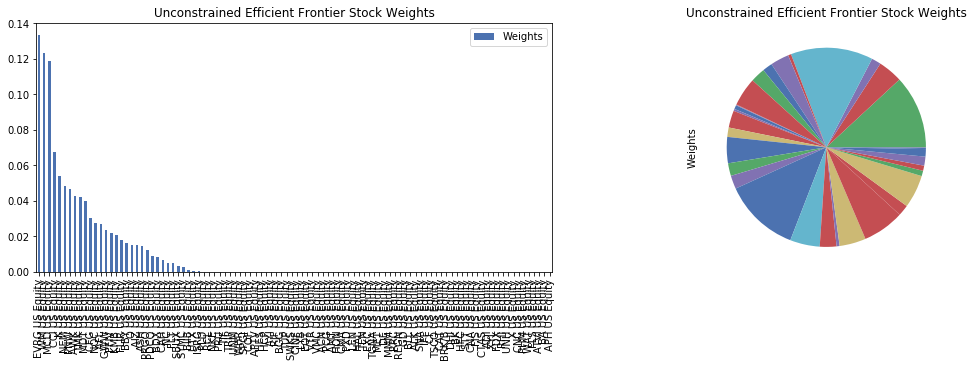

In [60]:
fig, axes  = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), constrained_layout=True)

portfolios_weights[index_best_return].sort_values("Weights", ascending=False).plot.bar(ax=axes[0], title = "Unconstrained Efficient Frontier Stock Weights");
portfolios_weights[index_best_return]["Weights"].plot.pie(ax=axes[1], labels = None, title = "Unconstrained Efficient Frontier Stock Weights");

In [61]:
p = list(portfolios_weights[index_best_return]["Weights"]);

num_small = len([i for i in range(len(p)) if p[i] <= 1e-4])
print(f"{num_small}/{len(list(random_portfolios[0].columns))} tickers have zero weight")

68/100 tickers have zero weight


In [62]:
smp500_sectors = pd.read_csv('../sectors.csv', index_col=0)
sector_mapper = smp500_sectors["GICS Sector"].to_dict()

In [63]:
asdf = dict()

for sector in set(sector_mapper.values()):
    total_weight = 0
    for t,w in portfolios_weights[index_best_return]["Weights"].items():
        if sector_mapper[t] == sector:
            total_weight += w
    asdf[sector] = total_weight
    
asdf = pd.DataFrame(data=asdf, index = [""])

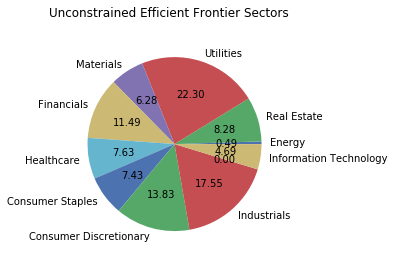

In [64]:
asdf.T.plot.pie(subplots=True, legend=False, autopct="%.2f", title="Unconstrained Efficient Frontier Sectors");

### Overall Best Sharpe

In [65]:
index_best_sharpe = results["Sharpe Ratio"].argmax()
results.loc[[index_best_sharpe]]

,Expected Return,Volatility,Sharpe Ratio
41,0.087233,0.074492,0.902551


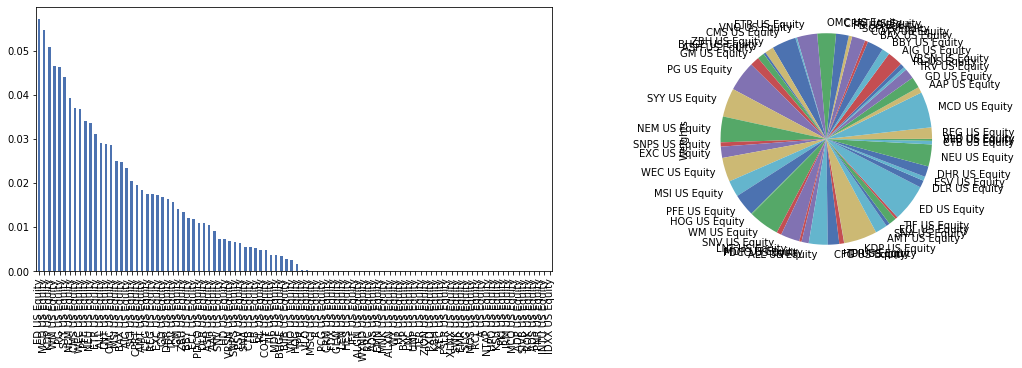

In [66]:
fig, axes  = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), constrained_layout=True)

portfolios_weights[index_best_sharpe]["Weights"].sort_values(ascending=False).plot.bar(ax=axes[0]);
portfolios_weights[index_best_sharpe]["Weights"].plot.pie(ax=axes[1]);

## Rebalancing
For a rebalancing portfolio, first examine one which has 1/N weight allocation, whereby N are the amount of stocks in the portfolio. 

In [ ]:
starting = 1000
rebal_portfolio = random_portfolios[0]
numberOfStocks = len(random_portfolios[0].columns)
weight_allocation = [1 / numberOfStocks for i in range(numberOfStocks)]
discrete_allocations = []

for i in range(numberOfStocks):
    discrete_allocations.append(weight_allocation[i]*starting / rebal_portfolio[rebal_portfolio.columns[i]][0])
    discrete_allocations[i] = round(discrete_allocations[i], 3);

print("Available funds: $", starting)
print("\nPortfolio: ", [i for i in rebal_portfolio.columns])
print("\nStock weights: ", weight_allocation)
print("Shares invested: ", discrete_allocations)

The top list, allocation_pct, provides the weightings for the stocks to be rebalanced.

The bottom list, discrete_allocations, provides the rebalancing baseline for which the stocks are to return to, allocation wise, when the stock prices change. 